In [1]:
#####################################
# Post Earnings Announcement Drift  #
# Qingyi (Freda) Song Drechsler     #
# Date: June 2019                   #
# Update: Jan 2021                  #
#####################################

# Update Note: this version uses CRSP data to extract S&P500 Index constituents,
# as comp.idxcst_hist data is no longer available on WRDS
# Also updated various .loc usage that has been deprecated by Python.

import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

# set sample date range
begdate = '01/01/2010'
enddate = '12/31/2018'

# set CRSP date range a bit wider to guarantee collecting all information
crsp_begdate = '01/01/2009'
crsp_enddate = '12/31/2019'

Loading library list...
Done


In [2]:
#################################
# Step 0: Read in ICLINK output #
#################################

# iclink.csv is the output from the python program iclink
# it contains the linking between crsp and ibes
iclink = pd.read_csv(Path.home().joinpath('wrds-code-samples/python/iclink.csv'))

In [3]:
##################################
# Step 1. S&P 500 Index Universe #
##################################

# All companies that were ever included in S&P 500 index as an example
# Old version of the code uses comp.idxcst_his

# New code uses crsp.msp500list
# Linking Compustat GVKEY and IBES Tickers using ICLINK               
# For unmatched GVKEYs, use header IBTIC link in Compustat Security file 


sp500 = conn.raw_sql(f"""
                        select a.*
                        from crsp.msp500list as a;
                        """, date_cols=['start', 'ending'])

# CCM data
_ccm = conn.raw_sql(""" select gvkey, lpermco as permco, lpermno as permno, 
                        linkdt, linkenddt 
                        from crsp.ccmxpf_linktable 
                        where usedflag=1 
                        and linkprim in ('P', 'C')""", date_cols=['linkdt', 'linkenddt'])

_ccm[['permco', 'permno']] = _ccm[['permco', 'permno']].astype(int)

# Fill linkenddt missing value (.E in SAS dataset) with today's date
_ccm['linkenddt'] = _ccm.linkenddt.fillna(datetime.date.today())

_sec = conn.raw_sql(""" select ibtic, gvkey from comp.security """)


# Start the sequence of left join
gvkey = pd.merge(sp500, _ccm, how='left', on=['permno'])
gvkey = pd.merge(gvkey, _sec.loc[_sec.ibtic.notna()], how='left', on=['gvkey'])

# high quality links from iclink
# score = 0 or 1
iclink_hq = iclink.loc[(iclink.score <=1)]

gvkey = pd.merge(gvkey, iclink_hq, how='left', on=['permno'])

# fill missing ticker with ibtic
gvkey.ticker = np.where(gvkey.ticker.notnull(), gvkey.ticker, gvkey.ibtic)

# Keep relevant columns and drop duplicates if there is any
gvkey = gvkey[['gvkey', 'permco', 'permno', 'linkdt', 'linkenddt','ticker']]

gvkey = gvkey.drop_duplicates()

# date ranges from gvkey
# min linkdt for ticker and permno combination
gvkey_mindt = gvkey.groupby(['ticker','permno']).linkdt.min().reset_index()

# max linkenddt for ticker and permno combination
gvkey_maxdt = gvkey.groupby(['ticker','permno']).linkenddt.max().reset_index()

# link date range 
gvkey_dt = pd.merge(gvkey_mindt, gvkey_maxdt, how='inner', on=['ticker','permno'])


# null unused dataframes to free memory
sp500 = None
_ccm = None
_ssec = None
iclink = None
gvkey_mindt = None
gvkey_maxdt = None

In [4]:
#######################################
# Step 2. Extract Estimates from IBES #
#######################################

# Extract estimates from IBES Unadjusted file and select    
# the latest estimate for a firm within broker-analyst group
# "fpi in (6,7)" selects quarterly forecast for the current 
# and the next fiscal quarter    

ibes_temp = conn.raw_sql(f"""
                        select ticker, estimator, analys, pdf, fpi, value, 
                        fpedats, revdats, revtims, anndats, anntims
                        from ibes.detu_epsus 
                        where fpedats between '{begdate}' and '{enddate}'
                        and (fpi='6' or fpi='7')
                        """, date_cols = ['revdats', 'anndats', 'fpedats'])


# merge to get date range linkdt and linkenddt to fulfill date requirement
ibes_temp = pd.merge(ibes_temp, gvkey_dt, how='left', on=['ticker'])
ibes_temp = ibes_temp.loc[(ibes_temp.linkdt<=ibes_temp.anndats) & (ibes_temp.anndats <= ibes_temp.linkenddt)]

In [5]:
# Count number of estimates reported on primary/diluted basis 

p_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='P']
d_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='D']

p_count = p_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'p_count'})
d_count = d_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'d_count'})

ibes = pd.merge(ibes_temp, d_count, how = 'left', on=['ticker', 'fpedats'])
ibes = pd.merge(ibes, p_count, how='left', on =['ticker','fpedats'])
ibes['d_count'] = ibes.d_count.fillna(0)
ibes['p_count'] = ibes.p_count.fillna(0)

# Determine whether most analysts report estimates on primary/diluted basis
# following Livnat and Mendenhall (2006)                                   

ibes['basis']=np.where(ibes.p_count>ibes.d_count, 'P', 'D')

ibes = ibes.sort_values(by=['ticker','fpedats','estimator','analys','anndats', 'anntims', 'revdats', 'revtims'])\
.drop(['linkdt', 'linkenddt','p_count','d_count', 'pdf', 'fpi'], axis=1)

# Keep the latest observation for a given analyst
# Group by company fpedats estimator analys then pick the last record in the group

ibes_1 = ibes.groupby(['ticker','fpedats','estimator','analys']).apply(lambda x: x.index[-1]).to_frame().reset_index()

# reset index to the old dataframe index for join in the next step
ibes_1=ibes_1.set_index(0)

# Inner join with the last analyst record per group
ibes = pd.merge(ibes, ibes_1[['analys']], left_index=True, right_index=True)

# drop duplicate column
ibes=ibes.drop(['analys_y'], axis=1).rename(columns={'analys_x': 'analys'})


# null unneeded dataframes
ibes_temp = None
p_sub = None
d_sub = None
p_count = None
d_count = None
gvkey_dt = None

In [6]:
#######################################
# Step 3. Link Estimates with Actuals #
#######################################

# Link Unadjusted estimates with Unadjusted actuals and CRSP permnos  
# Keep only the estimates issued within 90 days before the report date

# Getting actual piece of data
ibes_act = conn.raw_sql(f"""
                        select ticker, anndats as repdats, value as act, pends as fpedats, pdicity
                        from ibes.actu_epsus 
                        where pends between '{begdate}' and '{enddate}'
                        and pdicity='QTR'
                        """, date_cols = ['repdats', 'fpedats'])


# Join with the estimate piece of the data

ibes1 = pd.merge(ibes, ibes_act, how='left', on = ['ticker','fpedats'])
ibes1['dgap'] = ibes1.repdats - ibes1.anndats

ibes1['flag'] = np.where( (ibes1.dgap>=datetime.timedelta(days=0)) & (ibes1.dgap<=datetime.timedelta(days=90)) & (ibes1.repdats.notna()) & (ibes1.anndats.notna()), 1, 0)

ibes1 = ibes1.loc[ibes1.flag==1].drop(['flag', 'dgap', 'pdicity'], axis=1)

# Select all relevant combinations of Permnos and Date

ibes1_dt1 = ibes1[['permno', 'anndats']].drop_duplicates()

ibes1_dt2 = ibes1[['permno', 'repdats']].drop_duplicates().rename(columns={'repdats':'anndats'})

ibes_anndats = pd.concat([ibes1_dt1, ibes1_dt2]).drop_duplicates()

# null dataframes no longer needed to free memory
ibes1_dt1 = None
ibes1_dt2 = None
ibes_act = None



In [7]:
# Adjust all estimate and earnings announcement dates to the closest
# preceding trading date in CRSP to ensure that adjustment factors won't
# be missing after the merge  

# unique anndats from ibes
uniq_anndats = ibes_anndats[['anndats']].drop_duplicates()

# unique trade dates from crsp.dsi
crsp_dats = conn.raw_sql(""" 
                            select date 
                            from crsp.dsi 
                         """, date_cols=['date'])

# Create up to 5 days prior dates relative to anndats

for i in range(0, 5):
    uniq_anndats[i] = uniq_anndats.anndats - datetime.timedelta(days=i)

# reshape (transpose) the df for later join with crsp trading dates

expand_anndats = uniq_anndats.set_index('anndats').stack().reset_index().\
rename(columns={'level_1':'prior', 0:'prior_date'})

# merge with crsp trading dates
tradedates = pd.merge(expand_anndats, crsp_dats, how='left', left_on=['prior_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
tradedates['dgap'] = tradedates.anndats-tradedates.date

# choosing the row with the smallest dgap for a given anndats
tradedates = tradedates.loc[tradedates.groupby('anndats')['dgap'].idxmin()]

tradedates = tradedates[['anndats', 'date']]

# null unneeded dataframes
unique_anndats = None

In [8]:
# merge the CRSP adjustment factors for all estimate and report dates

# extract CRSP adjustment factors
cfacshr = conn.raw_sql(f"""
                        select permno, date, cfacshr
                        from crsp.dsf
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])

ibes_anndats = pd.merge(ibes_anndats, tradedates, how='left', on = ['anndats'])

ibes_anndats = pd.merge(ibes_anndats, cfacshr, how='left', on=['permno', 'date'])

# null unneeded datasets
cfacshr = None
tradedates = None

In [9]:
#########################################
# Step 4. Adjust Estimates with CFACSHR #
#########################################

# Put the estimate on the same per share basis as
# company reported EPS using CRSP Adjustment factors. 
# New_value is the estimate adjusted to be on the 
# same basis with reported earnings.

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', on=['permno', 'anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_ann'})

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', left_on=['permno', 'repdats'], right_on=['permno','anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_rep'})

ibes1['new_value'] = (ibes1.cfacshr_rep/ibes1.cfacshr_ann)*ibes1.value

# Sanity check: there should be one most recent estimate for 
# a given firm-fiscal period end combination 
ibes1 = ibes1.sort_values(by=['ticker','fpedats','estimator','analys']).drop_duplicates()

ibes = None # done w/ frame, free up memory
ibes_anndats = None


In [10]:
# Compute the median forecast based on estimates in the 90 days prior to the EAD

grp_permno = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).permno.max().reset_index()

medest = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).new_value.agg(['median','count']).reset_index()
medest = pd.merge(medest, grp_permno, how='inner', on=['ticker','fpedats','basis', 'repdats', 'act'])
medest = medest.rename(columns={'median': 'medest', 'count':'numest'})


ibes1 = None # null to free memory

In [11]:
######################################
# Step 5. Merge with Compustat Data  #
######################################

# get items from fundq
fundq = conn.raw_sql(f"""
                        select gvkey, fyearq, fqtr, conm, datadate, rdq, epsfxq, epspxq, cshoq, prccq, 
                        ajexq, spiq, cshoq, cshprq, cshfdq, saleq, atq, fyr, datafqtr, cshoq*prccq as mcap  
                        from comp.fundq 
                        where consol='C' and popsrc='D' and indfmt='INDL' and datafmt='STD'
                        and datadate between '{crsp_begdate}' and '{crsp_enddate}' 
                        """, date_cols = ['datadate', 'datafqtr', 'rdq'])

fundq = fundq.loc[((fundq.atq>0) | (fundq.saleq.notna())) & (fundq.datafqtr.notna())]


# Calculate link date ranges for givken gvkey and ticker combination

gvkey_mindt1 = gvkey.groupby(['gvkey', 'ticker']).linkdt.min().reset_index().rename(columns={'linkdt':'mindate'})
gvkey_maxdt1 = gvkey.groupby(['gvkey', 'ticker']).linkenddt.max().reset_index().rename(columns={'linkenddt':'maxdate'})
gvkey_dt1 = pd.merge(gvkey_mindt1, gvkey_maxdt1, how='inner', on=['gvkey','ticker'])


# Use the date range to merge
comp = pd.merge(fundq, gvkey_dt1, how='left', on =['gvkey'])
comp = comp.loc[(comp.ticker.notna()) & (comp.datadate<=comp.maxdate) & (comp.datadate>=comp.mindate)]

# Merge with the median esitmates
comp = pd.merge(comp, medest, how = 'left', left_on=['ticker','datadate'], right_on=['ticker', 'fpedats'])

# Sort data and drop duplicates
comp = comp.sort_values(by=['gvkey','fqtr','fyearq']).drop_duplicates()


# null unneeeded dataframes to free memory
gvkey = None
gvkey_dt1 = None
fundq = None
medest = None
gvkey_mindt1 = None
gvkey_maxdt1 = None

In [12]:
###########################
# Step 6. Calculate SUEs  #
###########################

# block handling lag eps

sue = comp.sort_values(by=['gvkey','fqtr','fyearq'])

sue['dif_fyearq'] = sue.groupby(['gvkey', 'fqtr']).fyearq.diff()
sue['laggvkey']   = sue.gvkey.shift(1)

# handling same qtr previous year

cond_year = sue.dif_fyearq==1 # year increment is 1

sue['lagadj']     = np.where(cond_year, sue.ajexq.shift(1), None)
sue['lageps_p']   = np.where(cond_year, sue.epspxq.shift(1), None)
sue['lageps_d']   = np.where(cond_year, sue.epsfxq.shift(1), None)
sue['lagshr_p']   = np.where(cond_year, sue.cshprq.shift(1), None)
sue['lagshr_d']   = np.where(cond_year, sue.cshfdq.shift(1), None)
sue['lagspiq']    = np.where(cond_year, sue.spiq.shift(1), None)

# handling first gvkey

cond_gvkey = sue.gvkey != sue.laggvkey # first.gvkey

sue['lagadj']     = np.where(cond_gvkey, None, sue.lagadj)
sue['lageps_p']   = np.where(cond_gvkey, None, sue.lageps_p)
sue['lageps_d']   = np.where(cond_gvkey, None, sue.lageps_d)
sue['lagshr_p']   = np.where(cond_gvkey, None, sue.lagshr_p)
sue['lagshr_d']   = np.where(cond_gvkey, None, sue.lagshr_d)
sue['lagspiq']    = np.where(cond_gvkey, None, sue.lagspiq)


# handling reporting basis 

# Basis = P and missing are treated the same

sue['actual1'] = np.where(sue.basis=='D', sue.epsfxq/sue.ajexq, sue.epspxq/sue.ajexq)

sue['actual2'] = np.where(sue.basis=='D', \
                            (sue.epsfxq.fillna(0)-(0.65*sue.spiq/sue.cshfdq).fillna(0))/sue.ajexq, \
                            (sue.epspxq.fillna(0)-(0.65*sue.spiq/sue.cshprq).fillna(0))/sue.ajexq
                           )

sue['expected1'] = np.where(sue.basis=='D', sue.lageps_d/sue.lagadj, sue.lageps_p/sue.lagadj)
sue['expected2'] = np.where(sue.basis=='D', \
                              (sue.lageps_d.fillna(0)-(0.65*sue.lagspiq/sue.lagshr_d).fillna(0))/sue.lagadj, \
                              (sue.lageps_p.fillna(0)-(0.65*sue.lagspiq/sue.lagshr_p).fillna(0))/sue.lagadj
                             )

# SUE calculations
sue['sue1'] = (sue.actual1 - sue.expected1) / (sue.prccq/sue.ajexq)
sue['sue2'] = (sue.actual2 - sue.expected2) / (sue.prccq/sue.ajexq)
sue['sue3'] = (sue.act - sue.medest) / sue.prccq

sue = sue[['ticker','permno','gvkey','conm','fyearq','fqtr','fyr','datadate','repdats','rdq', \
           'sue1','sue2','sue3','basis','act','medest','numest','prccq','mcap']]

# Shifting the announcement date to be the next trading day
# Defining the day after the following quarterly EA as leadrdq1

# unique rdq 
uniq_rdq = comp[['rdq']].drop_duplicates()

# Create up to 5 days post rdq relative to rdq
for i in range(0, 5):
    uniq_rdq[i] = uniq_rdq.rdq + datetime.timedelta(days=i)

# reshape (transpose) for later join with crsp trading dates
expand_rdq = uniq_rdq.set_index('rdq').stack().reset_index().\
rename(columns={'level_1':'post', 0:'post_date'})

# merge with crsp trading dates
eads1 = pd.merge(expand_rdq, crsp_dats, how='left', left_on=['post_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
eads1['dgap'] = eads1.date-eads1.rdq

# LOC deprecated, use reindex instead
#eads1 = eads1.loc[eads1.groupby('rdq')['dgap'].idxmin()].rename(columns={'date':'rdq1'})
eads1 = eads1.reindex(eads1.groupby('rdq')['dgap'].idxmin()).rename(columns={'date':'rdq1'})

# create sue_final
sue_final = pd.merge(sue, eads1[['rdq','rdq1']], how='left', on=['rdq'])
sue_final = sue_final.sort_values(by=['gvkey', 'fyearq','fqtr'], ascending=[True, False, False]).drop_duplicates()


# null unneeded dataframes
sue = None
comp = None
eads1 = None
crsp_dats = None
expand_rdq = None

In [13]:
#  Filter from Livnat & Mendenhall (2006):                                
#- earnings announcement date is reported in Compustat                   
#- the price per share is available from Compustat at fiscal quarter end  
#- price is greater than $1                                              
#- the market (book) equity at fiscal quarter end is available and is    
# EADs in Compustat and in IBES (if available)should not differ by more  
# than one calendar day larger than $5 mil.                              

sue_final['leadrdq1'] = sue_final.rdq1.shift(1) # next consecutive EAD
sue_final['leadgvkey'] = sue_final.gvkey.shift(1)

# If first gvkey then leadrdq1 = rdq1+3 months
# Else leadrdq1 = previous rdq1

sue_final['leadrdq1'] = np.where(sue_final.gvkey == sue_final.leadgvkey, 
                                  sue_final.rdq1.shift(1), 
                                  sue_final.rdq1 + pd.DateOffset(months=3))


#sue_final['dgap'] = (sue_final.repdats - sue_final.rdq).fillna(0)
sue_final['dgap'] = (sue_final.repdats - sue_final.rdq).fillna(pd.Timedelta(days=0))
sue_final = sue_final.loc[(sue_final.rdq1 != sue_final.leadrdq1)]

# Various conditioning for filtering
cond1 = (sue_final.sue1.notna()) & (sue_final.sue2.notna()) & (sue_final.repdats.isna())
cond2 = (sue_final.repdats.notna()) & (sue_final.dgap<=datetime.timedelta(days=1)) & (sue_final.dgap>=datetime.timedelta(days=-1))
sue_final = sue_final.loc[cond1 | cond2]

# Impose restriction on price and marketcap
sue_final = sue_final.loc[(sue_final.rdq.notna()) & (sue_final.prccq>1) & (sue_final.mcap>5)]

# Keep relevant columns
sue_final = sue_final[['gvkey', 'ticker','permno','conm', 'dgap',\
                       'fyearq','fqtr','datadate','fyr','rdq','rdq1','leadrdq1','repdats',\
                       'mcap','medest','act','numest','basis','sue1','sue2','sue3']]

In [14]:
#########################################
# Step 7. Form Portfolios Based on SUE  #
#########################################

# Extract file of raw daily returns around and between EADs and link them 
# to Standardized Earnings Surprises for forming SUE-based portfolios  
# Records from dsf and dsi to calculate exret
ds = conn.raw_sql(f"""
                        select permno, dsf.date, prc, abs(prc*shrout) as mcap, ret, vwretd
                        from crsp.dsf
                        left join crsp.dsi using(date)
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])
ds['exret'] = ds.ret - ds.vwretd
ds = ds.rename(columns={'vwretd':'mkt'})

# Records from sue_final that meet the condition
sue_final_join = sue_final.loc[(sue_final.rdq.notna()) & (sue_final.leadrdq1.notna()) & (sue_final.permno.notna()) \
                               & (sue_final.leadrdq1-sue_final.rdq1>datetime.timedelta(days=30))]
sue_final_join1 = sue_final_join.copy()
sue_final_join1['lb_date'] = sue_final_join.rdq1-datetime.timedelta(days=5)
sue_final_join1['ub_date'] = sue_final_join.leadrdq1+datetime.timedelta(days=5)

sue_final_join = None # null orig copy to free memory
sue_final = None
sfj_indexed = sue_final_join1[['permno','rdq1', 'leadrdq1','sue1','sue2','sue3', 'lb_date','ub_date']].set_index('permno')
sue_final_join1 = None
# downcasting the columns in ds reduces the size by about ~40%
# this savings is needed for the expensive join
for col in ['prc','mcap','ret','mkt','exret']:
    ds[col] = pd.to_numeric(ds[col], downcast='float')
ds['permno'] = pd.to_numeric(ds['permno'], downcast='integer')

#category is useful for repeated objects/strings/numbers
#while this operation will increase sfj_indexed's size it will reduce
#the size of the resulting join b/c these values will be repeated
for col in ['sue1','sue2','sue3']:
    sfj_indexed[col] = sfj_indexed[col].astype('category')
    
#the commented out join is very memory intensive >15GB RAM
#break it into chunks and filter as we go to keep it under that
# crsprets = ds.join(sfj_indexed, how='left', on='permno')
# crsprets.query('date<=ub_date', inplace=True)
# crsprets.query('date>=lb_date', inplace=True)
crsprets = pd.DataFrame()
n = 20000 #20000 needs about 14GB, 10000 about 10GB
for i in range(0, sfj_indexed.shape[0], n): 
    chunks =   sfj_indexed.iloc[i:i + n]
    merged = ds.join(chunks, on='permno', how='left')
    chunks = None
    merged.query('date<=ub_date', inplace=True)
    merged.query('date>=lb_date', inplace=True)
    crsprets = pd.concat([crsprets, merged] )
    merged = None

# null unneeded dataframes
ds = None
sfj_indexed = None
crsprets = crsprets.drop(['lb_date','ub_date'], axis=1)

In [15]:
# To estimate the drift, sum daily returns over the period from  
# 1 day after the earnings announcement through the day of       
# the following quarterly earnings announcement       

temp = crsprets.sort_values(by=['permno', 'rdq1', 'date'])
temp['lpermno'] = temp.permno.shift(1)

# If first permno then lagmcap = missing 
# Else lagmcap = lag(mcap)
temp['lagmcap'] = np.where(temp.permno == temp.lpermno, 
                                  temp.mcap.shift(1), 
                                  None)

temp = temp.loc[(temp.rdq1<=temp.date) & (temp.date<=temp.leadrdq1)]

# create count variable within the group
temp['ncount'] = temp.groupby(['permno','rdq1']).cumcount()


In [16]:

# Form quintiles based on SUE
peadrets = temp.sort_values(by=['ncount','permno','rdq1']).drop_duplicates()

peadrets['sue1r']=peadrets.groupby('ncount')['sue1'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
peadrets['sue2r']=peadrets.groupby('ncount')['sue2'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
peadrets['sue3r']=peadrets.groupby('ncount')['sue3'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))

# Form portfolios on Compustat-based SUEs (=sue1 or =sue2) or IBES-based SUE (=sue3)
# Code uses sue3

peadrets3 = peadrets.loc[peadrets.sue3r.notna()].sort_values(by=['ncount', 'sue3'])
peadrets3['sue3r'] = peadrets3['sue3r'].astype(int)

# Form value-weighted exret
# Calculate group weight sum;
grp_lagmcap = peadrets3.groupby(['ncount','sue3r']).lagmcap.sum().reset_index().rename(columns={'lagmcap':'total_lagmcap'})

# join group weight sum back to the df
peadrets3 = pd.merge(peadrets3, grp_lagmcap, how='left', on=['ncount','sue3r'])

# vw exret
peadrets3 = peadrets3.loc[peadrets3.total_lagmcap > 0]

peadrets3['wt_exret'] = peadrets3.exret * peadrets3.lagmcap / peadrets3.total_lagmcap
peadsue3port = peadrets3.groupby(['ncount', 'sue3r']).wt_exret.sum().reset_index()


# set ncount=0 all five portfolio weighted returns to be 0
peadsue3port['wt_exret'] = np.where(peadsue3port.ncount==0, 0, peadsue3port.wt_exret)

# transpose table for cumulative return calculation
peadsue3port = peadsue3port.pivot_table(index=['ncount'], columns='sue3r')

# reset column index level
peadsue3port.columns = [col[1] for col in peadsue3port.columns]
peadsue3port = peadsue3port.reset_index()

# keep only first 50 days after EADs
peadsue3port = peadsue3port.loc[peadsue3port.ncount<=50]

# Cumulating Excess Returns

peadsue3port['sueport1'] = peadsue3port[0].cumsum()
peadsue3port['sueport2'] = peadsue3port[1].cumsum()
peadsue3port['sueport3'] = peadsue3port[2].cumsum()
peadsue3port['sueport4'] = peadsue3port[3].cumsum()
peadsue3port['sueport5'] = peadsue3port[4].cumsum()

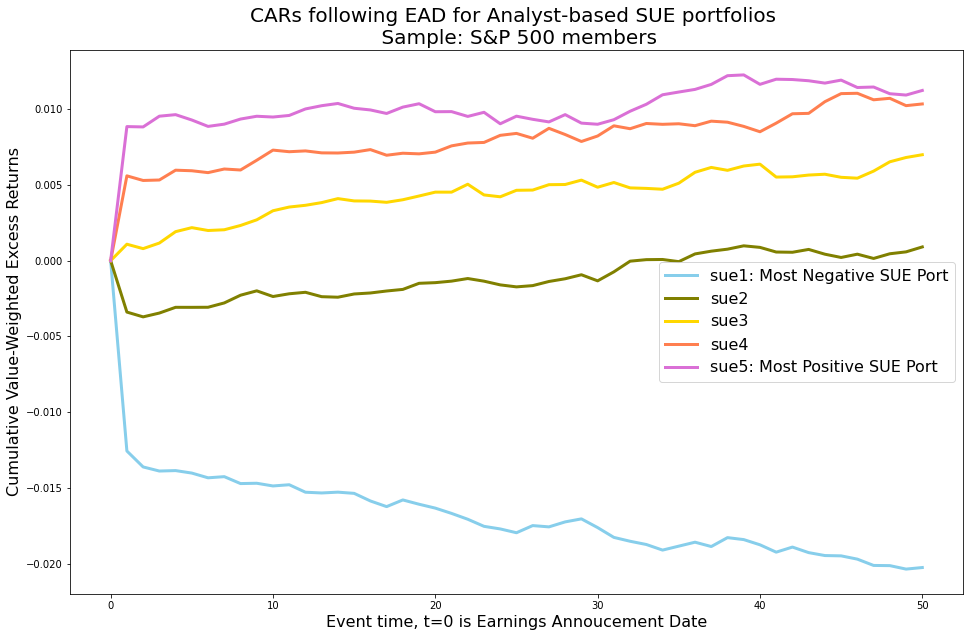

In [17]:
# Plotting the output

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,10))
plt.title('CARs following EAD for Analyst-based SUE portfolios \n Sample: S&P 500 members', fontsize=20)
plt.xlabel('Event time, t=0 is Earnings Annoucement Date', fontsize=16)
plt.ylabel('Cumulative Value-Weighted Excess Returns', fontsize=16)

plt.plot('ncount', 'sueport1', data=peadsue3port, color='skyblue', linewidth=3, label="sue1: Most Negative SUE Port")
plt.plot('ncount', 'sueport2', data=peadsue3port, color='olive', linewidth=3, label="sue2")
plt.plot('ncount', 'sueport3', data=peadsue3port, color='gold', linewidth=3, label="sue3")
plt.plot('ncount', 'sueport4', data=peadsue3port, color='coral', linewidth=3, label="sue4")
plt.plot('ncount', 'sueport5', data=peadsue3port, color='orchid', linewidth=3, label="sue5: Most Positive SUE Port")

plt.legend(loc="best", fontsize=16)

#uncomment and edit these lines to save the png output
#from pathlib import Path
#fig.savefig(os.path.join(Path.home(), '<your_subdirectory>', 'pead_08_18.png'))